In [1]:
using JuMP, Ipopt
using Plots

basicTerrain(x, y) = exp(-1(x^2 + y^2)) + exp(-0.5((x-2)^2 + y^2)) 

function potential(vec)
    return basicTerrain(vec[1], vec[2])
end

k = 4              
instances = zeros(Int,4)  
wps = zeros(2,k)    

instances[1] = 1
instances[2] = 30
instances[3] = 70
instances[4] = 100

# define waypoints
wps = [-2 -2;
        0  0;
        1  0;
       -2 -2]

function least_dangerous(λ, ξ) 

    m = Model(Ipopt.Optimizer)
    register(m, :basicTerrain, 2, basicTerrain, autodiff=true)
    register(m, :sum, 1, sum; autodiff = true)
    set_optimizer_attributes(m, "print_level" => 0 )
    @variable(m, position[1:instances[k], 1:2]) # Position
    @variable(m, velocity[1:instances[k], 1:2]) # Velocity
    @variable(m, thrust[1:instances[k], 1:2])   # Thrust

    # Dynamics (no initial velocity)
    @constraint(m, velocity[1,:] .== [0 0])

    @constraint(m, [-0.5 -0.5] .<= velocity .<= [0.5 0.5])
    @constraint(m, [-0.5 -0.5] .<= thrust .<= [0.5 0.5])

    for t in 1:instances[k]-1
        # Position is updated in thrust
        @constraint(m, position[t+1,:] .== position[t,:] + velocity[t,:])
        @NLconstraint(m, velocity[t+1,:1] == velocity[t,:1] + thrust[t,:1] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
        @NLconstraint(m, velocity[t+1,:2] == velocity[t,:2] + thrust[t,:2] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
        @NLconstraint(m, sum(abs(thrust[t,:1])) <= 100)
        @NLconstraint(m, sum(abs(thrust[t,:2])) <= 100)
    end

    # Reach all waypoints
    for i in [1 k]
        @constraint(m, position[instances[i],:] .== wps[i,:])
    end

    @objective(m, Min, sum(thrust.^2) + λ * sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ) )
    optimize!(m)
    
    J1 = value.(sum(thrust.^2))
    J2 = value.(sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ))
    velocity = value.(velocity)
    thrust = value.(thrust)
    path = value.(position)
    
    return (velocity,thrust,path)
end

least_dangerous (generic function with 1 method)

In [2]:
λ = 10
ξ = 1
(velocity,thrust,path) = least_dangerous(λ, ξ)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



([9.017522494176782e-25 3.8594337740792686e-24; 0.005938581732039993 0.04521582974153971; … ; -0.12155333919472683 -0.08744256469618593; -0.1210904557320149 -0.08697969566464775], [0.005938581732039993 0.04521582974153971; 0.008686162072685062 0.042408365478476734; … ; 1.0233931215022284e-8 -4.197242530800638e-9; -1.3841938825563078e-8 -1.384185494700399e-8], [-2.0 -2.0; -2.0 -2.0; … ; -1.8784466608052732 -1.9125574353038142; -2.0 -2.0])

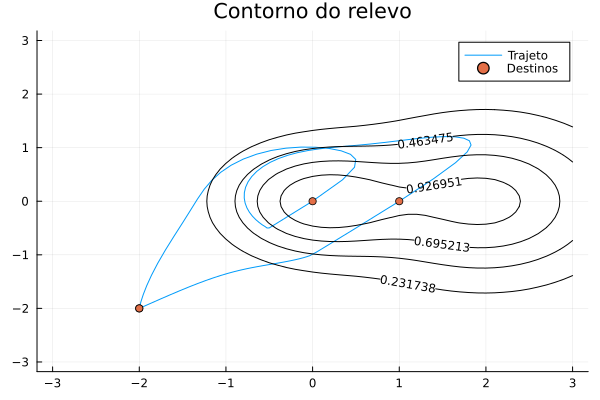

In [3]:
plot(path[:,1], path[:,2], label="Trajeto")
scatter!(wps[:,1], wps[:,2], label="Destinos")
contour!(-3:0.1:3, -3:0.1:3, basicTerrain, color=:black, clabels=true, levels=4, cbar=false, title="Contorno do relevo")

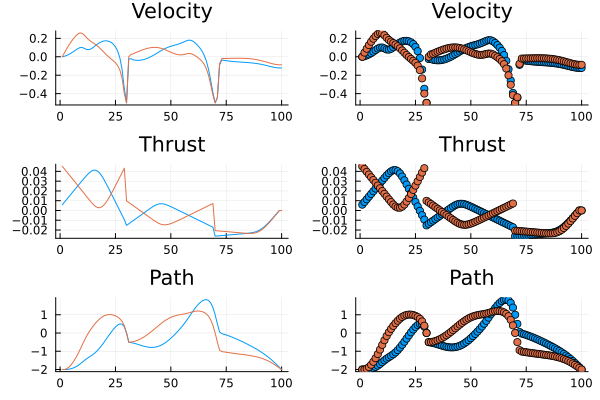

In [4]:
#velocity, impulse and route plot
p1 = plot(velocity, title="Velocity")
p2 = plot(velocity, seriestype=:scatter, label="data", title="Velocity")

p3 = plot(thrust, title="Thrust")
p4 = plot(thrust, seriestype=:scatter, label="data", title="Thrust")

p5 = plot(path, title="Path")
p6 = plot(path, seriestype=:scatter, label="data", title="Path")

plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), legend=false)



#plot!(sqrt.(thrust[1,:].^2 + thrust[2,:].^2))
#plot!(basicTerrain.(path...))


[0.008398422826712063, 0.012284088208162009, 0.01616959397373889, 0.020054868044668345, 0.02393975776195172, 0.027823889008562874, 0.031706361050572035, 0.03558496525438773, 0.03945403909732851, 0.043298845787564794, 0.04708132189694845, 0.05071045954203647, 0.05400220437762537, 0.056651106808422155, 0.05825200863775985, 0.058401888321728844, 0.05685815327994109, 0.053657480613212453, 0.049102893593864445, 0.043625185893797776, 0.03762249451605665, 0.03137144299434416, 0.02502405994633656, 0.018647931188476678, 0.01226730081283885, 0.005888971565922394, 0.0004856715365728699, 0.0068568441836255834, 0.013225893822374832, 0.02158674295106637, 0.01928811581224597, 0.016989379044142862, 0.014690667872754967, 0.012391990365122174, 0.010093220120136644, 0.007794672367002284, 0.005495941960680482, 0.0031972552781430884, 0.0008988814334603904, 0.001393479990636386, 0.0036495566272127457, 0.005781503845707677, 0.0076281443670656954, 0.008992660279302275, 0.009723616613094736, 0.0097815155218538

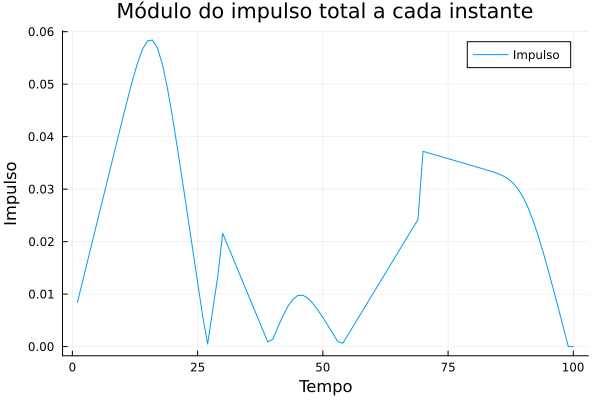

In [5]:
#Modulus of the total impulse at each instant
j = sqrt.(thrust[:,1].^2  + thrust[:,1].^2) 
println(j) #module value


plot(sqrt.(thrust[:,1].^2  + thrust[:,1].^2), label="Impulso", title="Módulo do impulso total a cada instante", xlabel="Tempo", ylabel="Impulso")